# Un peu d'apprentissage automatique avec NumPy

Nous allons effectuer un petit peu d'apprentissage automatique, qui est une sous-branche de l'intelligence artificielle, pour illustrer l'utilisation du paquet `numpy`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Régression logistique

La régression logistique est un modèle linéaire pour des tâches de classification binaire.
L'objectif n'est pas de prédire un nombre réel mais une classe parmi deux choix possibles (par exemple *malade* ou *sain* dans le domaine médical).
L'algorithme s'étend aux tâches de classification multiclasse, c'est-à-dire avec un nombre de classes strictement plus grand que deux, mais nous nous limiterons à la classification binaire ici.

Un modèle linéaire de classification binaire sépare l'espace en deux sous-espaces par un hyperplan.
En classification binaire, on fait souvent référence aux deux classes par les termes *classe positive* et *classe négative*.

Le modèle prédit comme :

* observation positive tout point du plan dont la distance signée à l'hyperplan est positive, et
* observation négative tout point du plan dont la distance signée à l'hyperplan est négative.


### Cas où les classes sont linéairement séparables

Tout d'abord, on utilise la fonction [`sklearn.datasets.make_classification()`](https://scikit-learn.org/1.6/modules/generated/sklearn.datasets.make_classification.html) pour créer un jeu de données avec seulement deux variables en entrée pour pouvoir facilement visualiser le jeu de données :

In [11]:
from sklearn.datasets import make_classification

X_log_sep, y_log_sep = make_classification(
    n_samples=40, n_features=2, n_informative=2, n_repeated=0, n_redundant=0,
    n_clusters_per_class=1, flip_y=0, class_sep=2, random_state=42,
)

Deux variables Python ont été créées :
* `X_log_sep` correspond à la matrice $\mathbf{X}$ contenant les entrées,
* `y_log_sep` correspond au vecteur $\mathbf{y}$ contenant les sorties (c'est-à-dire les classes, $0$ ou $1$).

**Question 8 : Effectuez une visualisation du jeu de données. Est-ce que les classes sont linéairement séparables ?**

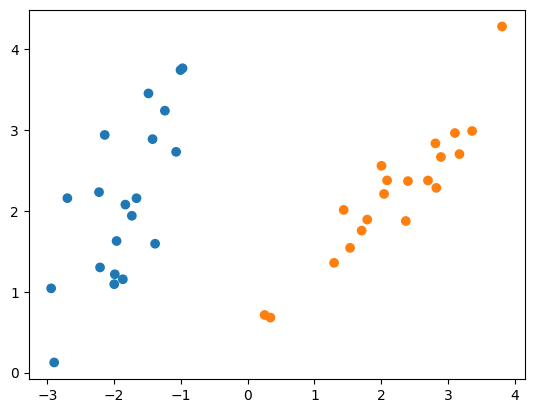

In [12]:
plt.scatter(X_log_sep[:, 0], X_log_sep[:, 1], c=np.array(['C0', 'C1'])[y_log_sep])
plt.show()

**Réponse** : On voit visuellement que les données sont linéairement séparables, (donc aussi en enlevant quelques observations pour les réserver pour le jeu d'évaluation).
On s'attend donc à pouvoir obtenir un modèle de classification parfait avec une régression logistique.

Pour un hyperplan caractérisé par le vecteur $\mathbf{w}$, la distance signée d'un point $\mathbf{x}$ à l'hyperplan est le produit scalaire entre les deux vecteurs :

$$
    f(\mathbf{x}; \mathbf{w}) = \mathbf{w}^\top \mathbf{x}
$$

On fait encore l'hypothèse d'avoir rajouter une variable supplémentaire au vecteur $\mathbf{x}$ contenant un `1` pour modéliser la constante.

**Question 9 : Ajoutez une colonne de 1 en tant que dernière colonne à la matrice `X_log_sep` pour modéliser la constante.**

In [13]:
X_log_sep = np.hstack((X_log_sep, np.ones((X_log_sep.shape[0], 1))))

La régression logistique est un modèle probabiliste avec l'hypothsèse suivante :

$$
    P(y=1 \vert \mathbf{x}) = \sigma \left( \mathbf{w}^\top \mathbf{x} \right)
$$

où $\sigma$ est la fonction sigmoïde définie par :

$$
    \sigma(x) = \frac{1}{1 + \exp(-x)}
$$

**Question 10 : Définissez une fonction `sigmoid()` qui prend en argument un tableau NumPy et qui renvoie le tableau NumPy de même forme où la fonction sigmoïde a été appliquée à chaque élément du tableau.**

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Pour trouver les paramètres optimaux (l'hyperplan $\mathbf{w}$), on cherche encore à minimiser une fonction de coût notée $J$ :

$$
    \mathbf{w}^* = \arg\min_{\mathbf{w}} J(\mathbf{w})
$$

On utilise l'[entropie croisée](https://fr.wikipedia.org/wiki/Entropie_croisée) comme critère :

$$
    J(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n - y^{(i)} \log \left( \sigma \left( \mathbf{w}^\top \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - \sigma \left( \mathbf{w}^\top \mathbf{x}^{(i)} \right) \right)
$$

Le gradient de cette fonction par rapport à $\mathbf{w}$ est noté $\nabla_{\mathbf{w}} J$ :

$$
    \nabla_{\mathbf{w}} J(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left( \sigma \left( \mathbf{w}^\top \mathbf{x}^{(i)} \right) - y^{(i)} \right) \mathbf{x}^{(i)}
$$

Il n'existe pas d'[expression de forme fermée](https://fr.wikipedia.org/wiki/Expression_de_forme_fermée) pour résoudre l'équation $\nabla_{\mathbf{w}} J(\mathbf{w}) = 0$.
On va donc implémenter à la place une [descente du gradient](https://fr.wikipedia.org/wiki/Algorithme_du_gradient) pour trouver les paramètres optimaux.

* Paramètres :
    + `X` : matrice des entrées
    + `y` : vecteur des sorties
    + `max_iter` : nombre maximum d'itérations
    + `tol` : tolerance (sur la norme infinie du gradient)
    + `lr` : taux d'apprentissage $\eta$
* Initialiser les coefficients à 0 : $\mathbf{w}^{(0)}$
* Calculer le gradient $\nabla_{\mathbf{w}} J(\mathbf{w}^{(0)})$
* Si la norme infinie du gradient est inférieure à `tol`
    + Renvoyer les résultats : l'initialisation convient
* Tant que le nombre maximum d'itérations n'est pas atteint
    + Mettre à jour les coefficients avec la formule suivante : $\mathbf{w}^{(t)} = \mathbf{w}^{(t-1)} - \eta \times \nabla_{\mathbf{w}} J(\mathbf{w}^{(t-1)})$
    + Calculer le gradient $\nabla_{\mathbf{w}} J(\mathbf{w}^{(t)})$
    + Si la norme infinie du gradient est inférieure à `tol`
        - Arrêter
* Renvoyer les coefficients, si l'algorithme a convergé et le nombre d'itérations effectuées.

Pour rappel, la norme infinie d'un vecteur est définie par :
$$
    \Vert \mathbf{x} \Vert_{\infty} = \max_{j} \vert x_j \vert
$$

**Question 11 : Définissez une fonction `norm()` qui renvoie la norme infinie d'un tableau NumPy.**

In [15]:
def norm(x):
    return np.max(np.abs(x))

**Question 12 : Définissez une fonction `gradient_logistic_regression()` qui prend en arguments la matrice des entrées $\mathbf{X}$, le vecteur des sorties $\mathbf{y}$ et le vecteur des coefficients $\mathbf{w}$, et qui renvoie le gradient $\nabla_{\mathbf{w}} J(\mathbf{w})$.**

In [16]:
def gradient_logistic_regression(X, y, w):
    return ((sigmoid(X @ w) - y).reshape(-1, 1) * X).mean(axis=0)

**Question 13 : Définissez une fonction `gradient_descent()` qui implémente l'algorithme de descente de gradient défini ci-dessus et qui renvoie un dictionnaire avec les informations suivantes :**

* La clé `'coef'` a pour valeur les coefficients obtenus à la dernière itération effectuée.
* La clé `'convergé'` a pour valeur un booléen indiquant si l'algorithme a convergé ou non.
* La clé `'n_iter'` a pour valeur le nombre d'itérations effectuées.

In [ ]:
def gradient_descent(X, y, max_iter, tol, lr):

    # Initialisation des coefficients
    w = np.zeros(X.shape[1])

    # Calcul du gradient
    grad = gradient_logistic_regression(X, y, w)

    # Si la norme infinie du gradient est inférieure à tol
    if norm(grad) < tol:

        # Renvoyer les résultats
        return {'coef': w, 'convergé': True, 'n_iter': 0}

    # Initialisation de la convergence
    converge = False

    # Tant que le nombre maximum d'itérations n'est pas atteint
    for n_iter in range(1, max_iter + 1):

        # Mettre à jour les coefficients
        w -= lr * grad

        # Calculer le gradient
        grad = gradient_logistic_regression(X, y, w)

        # Si la norme infinie du gradient est inférieure à tol
        if norm(grad) < tol:

            # Il y a convergence : arrêter l'algorithme
            converge = True
            break

    # Renvoyer les résultats
    return {'coef': w, 'convergé': converge, 'n_iter': n_iter}

**Question 14 : Appelez la fonction `gradient_descent()` avec les valeurs suivantes : `max_iter=10_000, tol=1e-4` et le taux d'apprentissage `lr` prenant ses valeurs dans `[10.0 ** k for k in range(-3, 3)]`. Sauvegardez les résultats dans un seul dictionnaire dont les clés sont les valeurs du taux d'apprentissage.**

In [18]:
res_sep = {}
for lr in [10.0 ** k for k in range(-3, 3)]:
    res_sep[lr] = gradient_descent(X_log_sep, y_log_sep, max_iter=10_000, tol=1e-3, lr=lr)

**Question 15 : Définissez une fonction `plot_decision_functions()` qui affiche sur un même graphique 6 figures, où chaque figure affiche le jeu de données et l'hyperplan appris de la régression logistique pour ce taux d'apprentissage. Indiquez dans le titre de chaque sous-figure les informations pertinentes.**

In [ ]:
def plot_decision_functions(X, y, res):
    from math import ceil

    plt.figure(figsize=(12, 3 * ceil(len(res) / 3)))

    for i, lr in enumerate(res):

        # Récupère les coefficients
        w = res[lr]['coef']

        plt.subplot(ceil(len(res) / 3), 3, i + 1)

        # Affiche le jeu de données
        plt.scatter(X[:, 0], X[:, 1], c=np.array(['C0', 'C1'])[y], s=10)

        # Récupère les valeurs limites des axes
        xlim = plt.xlim()
        ylim = plt.ylim()

        # Affiche l'hyperplan
        plt.plot(
            xlim,
            [(w[2] + w[0] * xlim[0]) / (-w[1]), (w[2] + w[0] * xlim[1]) / (-w[1])],
            color='k'
        )

        # Titre
        title = (
            f"lr = {lr} - "
            f"{'C' if res[lr]['convergé'] else 'Pas de c'}"
            f"onvergence en {res[lr]['n_iter']} itération"
            f"{'s' if res[lr]['n_iter'] > 1 else ''}"
        )
        plt.title(title, fontsize=8)

        # Redonne aux valeurs limites des axes leurs valeurs d'origine
        plt.xlim(xlim)
        plt.ylim(ylim)

        # Diminue la taille des marques sur chaque axe
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)

    plt.show()

**Question 16 : Appelez cette fonction. Que constatez-vous ?**

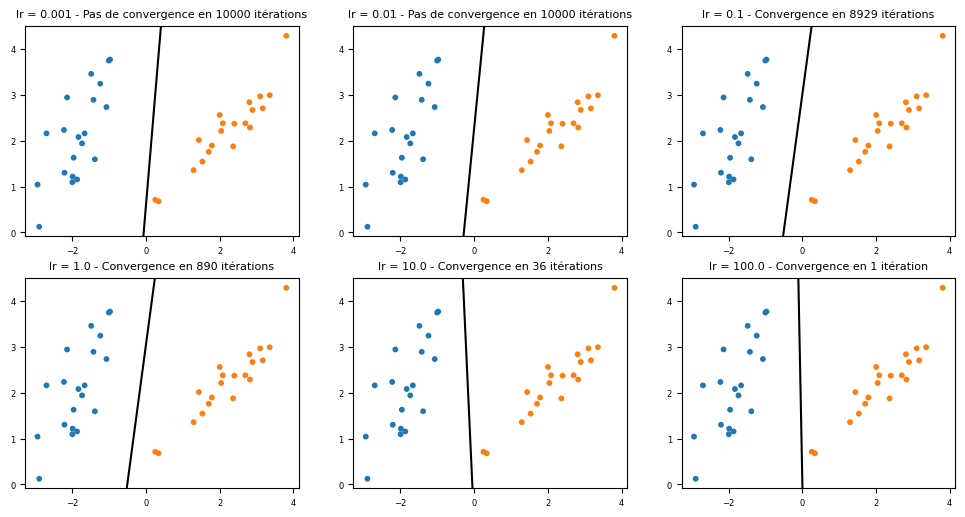

In [20]:
plot_decision_functions(X_log_sep, y_log_sep, res_sep)

**Réponse** :

1. Les modèles avec les taux d'apprentissage les plus faibles n'ont pas convergé, alors que les modèles avec les taux d'apprentissage les plus élevés ont convergé.
2. Bien que les modèles avec les taux d'apprentissage les plus faibles n'aient pas convergé, les coefficients finaux pour tous les modèles séparent parfaitement les deux classes.
3. Parmi les modèles ayant convergé, les coefficients obtenus ne sont pas toujours les mêmes.

**Question 17 : Définissez une fonction `accuracy()` qui prend en arguments la matrice des entrées $\mathbf{X}$, le vecteur des sorties $\mathbf{y}$ et le vecteur des coefficients $\mathbf{w}$, et qui renvoie la proportion de bonnes prédictions effectuées par le modèle.** 

In [21]:
def accuracy(X, y, w):
    return ((X @ w > 0).astype('int64') == y).mean()

**Question 18 : Utilisez cette fonction pour vérifier que la proportion de bonnes prédictions effectuées par chacun des modèles est bien égale à 1.**

In [22]:
for lr in res_sep:
    assert accuracy(X_log_sep, y_log_sep, res_sep[lr]['coef']) == 1.0

### Cas où les classes ne sont pas linéairement séparables

On s'intéresse maintenant au cas plus réaliste où les classes ne sont pas linéairement séparables.
On utilise à nouveau la fonction [`sklearn.datasets.make_classification()`](https://scikit-learn.org/1.6/modules/generated/sklearn.datasets.make_classification.html) pour créer un tel jeu de données :

In [23]:
X_log, y_log = make_classification(
    n_samples=40, n_features=2, n_informative=2, n_repeated=0, n_redundant=0,
    n_clusters_per_class=1, flip_y=0.2, class_sep=0.8, random_state=42,
)

**Question 19 : Effectuez une visualisation du jeu de données. Est-ce que les classes ne sont pas linéairement séparables ?**

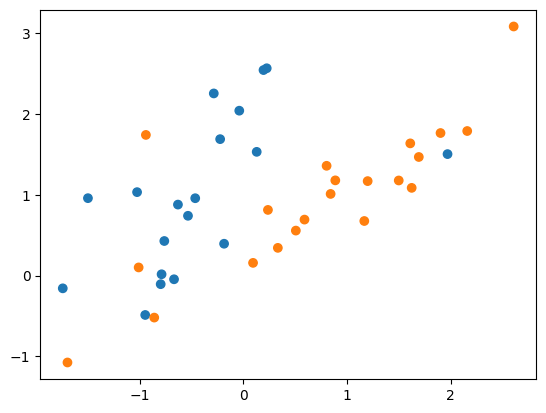

In [24]:
plt.scatter(X_log[:, 0], X_log[:, 1], c=np.array(['C0', 'C1'])[y_log])
plt.show()

**Question 20 : Ajoutez une colonne de 1 en tant que dernière colonne à la matrice `X_log` pour modéliser la constante.**

In [25]:
X_log = np.hstack((X_log, np.ones((X_log.shape[0], 1))))

**Question 21 : Répétez les questions 14 et 16 pour ce jeu de données.**

In [26]:
res = {}
for lr in [10.0 ** k for k in range(-3, 3)]:
    res[lr] = gradient_descent(X_log, y_log, max_iter=10_000, tol=1e-3, lr=lr)

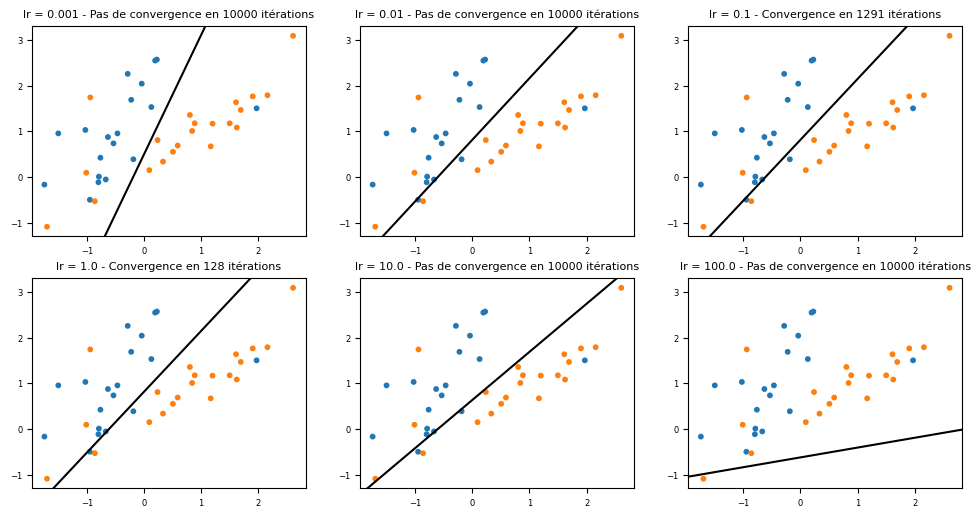

In [27]:
plot_decision_functions(X_log, y_log, res)

**Réponse** :

1. Les modèles avec des taux d'apprentissage trop faibles ou trop élevés n'ont pas convergé, tandis que les autres ont convergé.
2. Pour les modèles ayant convergé, les coefficients obtenus sont assez similaires (interprétation visuelle uniquement).


On constate que le taux d'apprentissage est un hyperparamètre important car :

* s'il est trop élevé, l'algorithme ne vas pas converger (vers la valeur optimale), et
* s'il est trop faible, l'algorithme va mettre trop de temps à converger.

Il existe une borne supérieure qui permet d'affirmer que si le taux d'apprentissage est inférieur à cette borne supérieure, alors l'algorithme converge forcément (avec assez d'itérations) vers la solution optimale.
Cette borne supérieure est l'inverse de la plus grande valeur propre de la matrice hessienne de la fonction de coût.

La matrice hessienne de la fonction de coût est :
$$
    \nabla_{\mathbf{w}}^2 J(\mathbf{w}) 
    = \frac{1}{n} \sum_{i=1}^n \sigma \left( \mathbf{w}^\top \mathbf{x}^{(i)} \right) \left( 1 - \sigma \left( \mathbf{w}^\top \mathbf{x}^{(i)} \right) \right) \mathbf{x}^{(i)} \mathbf{x}^{(i)\top}
    = \frac{1}{n} \mathbf{X}^\top \mathbf{D} \mathbf{X}
    \qquad\text{avec}\qquad
    \mathbf{D} = \text{diag}\left( \left[ \sigma \left( \mathbf{w}^\top \mathbf{x}^{(i)} \right) \left( 1 - \sigma \left( \mathbf{w}^\top \mathbf{x}^{(i)} \right) \right) \right]_{i=1}^p \right)
$$

La matrice hessienne dépend du point d'évaluation $\mathbf{w}$ à travers la matrice diagonale $\mathbf{D}$. Néanmoins, si on trouve un majorant de $\mathbf{D}$ (en valeurs propres), alors on pourra calculer un majorant de la hessienne.

**Question 22 : Affichez la courbe de la fonction $x \mapsto \sigma(x) (1 - \sigma(x))$ sur l'intervalle $[-10, 10]$ pour déterminer visuellement le maximum de cette fonction. En déduire une matrice majorant (en valeurs propres) la hessienne.**

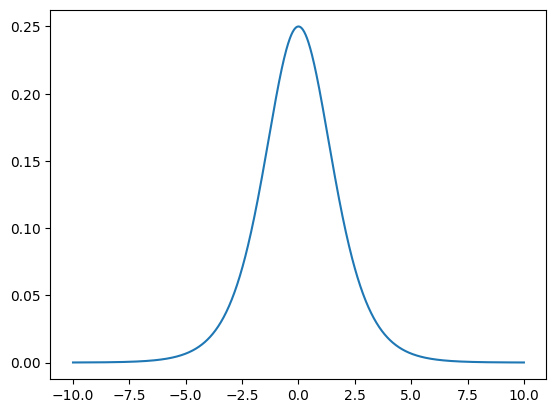

In [28]:
plt.plot(
    np.linspace(-10, 10, 1001),
    sigmoid(np.linspace(-10, 10, 1001)) * (1 - sigmoid(np.linspace(-10, 10, 1001)))
);

**Réponse** : Le majorant de la fonction $x \mapsto \sigma(x) (1 - \sigma(x))$ est $\frac{1}{4}$, atteint en $x=0$. Par conséquent, on a :
$$
    \forall \mathbf{w} \in \mathbb{R}^p, \; \nabla_{\mathbf{w}}^2 J(\mathbf{w}) \preceq \frac{1}{4n} X^\top X
$$

**Question 23 : En déduire, en utilisant la fonction [`scipy.linalg.eigh()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html) qui permet de calculer la plus grande valeur propre uniquement (voir les arguments `eigvals_only` et `subset_by_index`) d'une matrice, un majorant de la plus grande valeur propre de la hessienne de la fonction de coût.**

In [29]:
from scipy.linalg import eigh

eigh(
    X_log.T @ X_log,
    eigvals_only=True,
    subset_by_index=[X_log.shape[1] - 1, X_log.shape[1] - 1]
).item() / (4 * X_log.shape[0])

0.6940373812258426

**Question 24 : Définissez une nouvelle version de la fonction `gradient_descent_auto_lr()` qui ne prend plus un argument `lr` pour le taux d'apprentissage, mais qui le calcule automatiquement avec la méthodologie définie ci-dessus. Ajoutez le taux d'apprentissage utilisé dans le dictionnaire renvoyé par cette fonction.**

In [30]:
def gradient_descent_auto_lr(X, y, max_iter, tol):

    # Initialisation des coefficients
    w = np.zeros(X.shape[1])

    # Calcul du gradient
    grad = gradient_logistic_regression(X, y, w)

    # Si la norme infinie du gradient est inférieure à tol
    if norm(grad) < tol:

        # Renvoyer les résultats
        return {'coef': w, 'convergé': True, 'n_iter': 0, 'lr': None}

    # Calculer le taux d'apprentissage optimal
    lr = (4 * X.shape[0]) / eigh(
        X.T @ X, eigvals_only=True, subset_by_index=[X.shape[1] - 1, X.shape[1] - 1]
    ).item()

    # Initialisation de la convergence
    converge = False

    # Tant que le nombre maximum d'itérations n'est pas atteint
    for n_iter in range(1, max_iter + 1):

        # Mettre à jour les coefficients
        w -= lr * grad

        # Calculer le gradient
        grad = gradient_logistic_regression(X, y, w)

        # Si la norme infinie du gradient est inférieure à tol
        if norm(grad) < tol:

            # Il y a convergence : arrêter l'algorithme
            converge = True
            break

    # Renvoyer les résultats
    return {'coef': w, 'convergé': converge, 'n_iter': n_iter, 'lr': lr}

**Question 25 : Affichez les résultats obtenus avec cette fonction dans un graphique. Comparez ces résultats avec ceux obtenus à la question 21.**

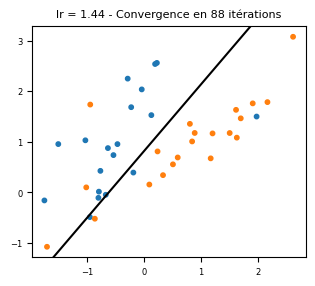

In [31]:
res_auto = gradient_descent_auto_lr(X_log, y_log, max_iter=10_000, tol=1e-3)

plot_decision_functions(
    X_log, y_log, {f"{res_auto['lr']:.2f}": res_auto}
)

**Réponse** :

1. Le taux d'apprentissage optimal (tout en garantissant la convergence) est environ égal à $1.44$
1. On obtient des coefficients similaires à ceux obtenus avec les taux d'apprentissage égaux à $0.1$ et $1$, mais avec un nombre d'itérations plus faible ($88$ contre $1291$ et $128$).